# Using with `pyspark` for data preprocessing

We want to use pyspark to preprocess a potentially huge dataset used for web-marketing.

## Data description

The data is a `parquet` file which contains a dataframe with 8 columns:

- `xid`: unique user id
- `action`: type of action. 'C' is a click, 'O' or 'VSL' is a web-display
- `date`: date of the action
- `website_id`: unique id of the website
- `url`: url of the webpage
- `category_id`: id of the display
- `zipcode`: postal zipcode of the user
- `device`: type of device used by the user

## Q1. Some statistics / computations

Using `pyspark.sql` we want to do the following things:

1. Compute the total number of unique users
2. Construct a column containing the total number of actions per user
3. Construct a column containing the number of days since the last action of the user
4. Construct a column containing the number of actions of each user for each modality of device 

## Q2. Binary classification

Then, we want to construct a classifier to predict the click on the category 1204. 
Here is an agenda for this:

1. Construction of a features matrix for which each line corresponds to the information concerning a user.
2. In this matrix, we need to keep only the users that have been exposed to the display in category 1204
3. Using this training dataset, train a binary classifier, and evaluate your classifier using a precision / recall curve computed on test data.

# Download/read the data and a first look at the data

In [1]:
import os
import sys
from pyspark.sql import SparkSession

spark = (SparkSession
    .builder
    .appName("Web data")         
    .getOrCreate()
)

In [2]:
import requests, zipfile, io
from pathlib import Path

path = Path('webdata.parquet')
if not path.exists():
    url = "https://stephanegaiffas.github.io/big_data_course/data/webdata.parquet.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='./')

In [6]:
input_path = './'

input_file = os.path.join(input_path, 'webdata.parquet')
df = spark.read.parquet(input_file)

In [7]:
df.head()

Row(xid='0056de77-4bb7-47a1-8be5-05c1699d4816', action='O', date=datetime.datetime(2017, 1, 14, 11, 9, 10), website_id='55', url='http://www.jeuxteleactu.com/the-wall-finalement-c-est-christophe-dechavanne-qui-presentera-le-nouveau-jeu-de-tf1', category_id=1204.0, zipcode='59500', device='DSK')

# Basic statistics

First we need to import some things

In [8]:
from pyspark.sql import Window
import pyspark.sql.functions as func
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit

## Compute the total number of unique users

In [9]:
df.select('xid').distinct().count()

473761

## Construct a column containing the total number of actions per user

In [10]:
xid_partition = Window.partitionBy('xid')
n_events = func.count(col('action')).over(xid_partition)
df = df.withColumn('n_events', n_events)
df.head(n=2)

[Row(xid='0008c5d2-c263-4b55-ae7d-82c4bf566cc4', action='O', date=datetime.datetime(2017, 1, 16, 3, 26, 21), website_id='74', url='http://www.realite-virtuelle.com/meilleure-videos-360-vr', category_id=1002.0, zipcode=None, device='DSK', n_events=1),
 Row(xid='002b8067-08be-4145-9a8f-6f183b03cd6c', action='O', date=datetime.datetime(2017, 1, 31, 14, 32, 46), website_id='4', url='http://www.jardipedia.com/forum/showthread.php?3925-amenagement-de-la-serre', category_id=1204.0, zipcode='08220', device='DSK', n_events=1)]

## Construct a column containing the number of days since the last action of the user

In [11]:
xid_partition = Window.partitionBy('xid')
max_date = func.max(col('date')).over(xid_partition)
n_days_since_last_event = func.datediff(func.current_date(), max_date)
df = df.withColumn('n_days_since_last_event',
                   n_days_since_last_event)
df.head(n=2)

[Row(xid='0008c5d2-c263-4b55-ae7d-82c4bf566cc4', action='O', date=datetime.datetime(2017, 1, 16, 3, 26, 21), website_id='74', url='http://www.realite-virtuelle.com/meilleure-videos-360-vr', category_id=1002.0, zipcode=None, device='DSK', n_events=1, n_days_since_last_event=1205),
 Row(xid='002b8067-08be-4145-9a8f-6f183b03cd6c', action='O', date=datetime.datetime(2017, 1, 31, 14, 32, 46), website_id='4', url='http://www.jardipedia.com/forum/showthread.php?3925-amenagement-de-la-serre', category_id=1204.0, zipcode='08220', device='DSK', n_events=1, n_days_since_last_event=1190)]

## Construct a column containing the number of actions of each user for each modality of device

In [12]:
xid_device_partition = Window.partitionBy('xid', 'device')
n_events_per_device = func.count(col('action')).over(xid_device_partition)
df = df.withColumn('n_events_per_device', n_events_per_device)
df.head(n=2)

[Row(xid='0008c5d2-c263-4b55-ae7d-82c4bf566cc4', action='O', date=datetime.datetime(2017, 1, 16, 3, 26, 21), website_id='74', url='http://www.realite-virtuelle.com/meilleure-videos-360-vr', category_id=1002.0, zipcode=None, device='DSK', n_events=1, n_days_since_last_event=1205, n_events_per_device=1),
 Row(xid='002b8067-08be-4145-9a8f-6f183b03cd6c', action='O', date=datetime.datetime(2017, 1, 31, 14, 32, 46), website_id='4', url='http://www.jardipedia.com/forum/showthread.php?3925-amenagement-de-la-serre', category_id=1204.0, zipcode='08220', device='DSK', n_events=1, n_days_since_last_event=1190, n_events_per_device=1)]

## Number of device per user: some mental gymnastics

In [13]:
xid_partition = Window.partitionBy('xid')
rank_device = func.dense_rank().over(xid_partition.orderBy('device'))
n_unique_device = func.last(rank_device).over(xid_partition)
df = df.withColumn('n_device', n_unique_device)
df.head(n=2)

[Row(xid='0008c5d2-c263-4b55-ae7d-82c4bf566cc4', action='O', date=datetime.datetime(2017, 1, 16, 3, 26, 21), website_id='74', url='http://www.realite-virtuelle.com/meilleure-videos-360-vr', category_id=1002.0, zipcode=None, device='DSK', n_events=1, n_days_since_last_event=1205, n_events_per_device=1, n_device=1),
 Row(xid='002b8067-08be-4145-9a8f-6f183b03cd6c', action='O', date=datetime.datetime(2017, 1, 31, 14, 32, 46), website_id='4', url='http://www.jardipedia.com/forum/showthread.php?3925-amenagement-de-la-serre', category_id=1204.0, zipcode='08220', device='DSK', n_events=1, n_days_since_last_event=1190, n_events_per_device=1, n_device=1)]

In [14]:
df\
    .where(col('n_device') > 1)\
    .select('xid', 'device', 'n_events',  'n_device', 'n_events_per_device')\
    .head(n=8)

[Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=5),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=5),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=5),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=5),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=5),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='MOB', n_events=6, n_device=2, n_events_per_device=1),
 Row(xid='78156cdf-7229-46eb-bb6b-92d384f9a6fa', device='DSK', n_events=6, n_device=2, n_events_per_device=5),
 Row(xid='78156cdf-7229-46eb-bb6b-92d384f9a6fa', device='DSK', n_events=6, n_device=2, n_events_per_device=5)]

# Let's select the correct users and build a training dataset

We construct a ETL (Extract Transform Load) process on this data using the `pyspark.sql` API.

## Extraction

Extraction is easy here, it's just about reading the data

In [15]:
df = spark.read.parquet(input_file)
df.head(n=3)

[Row(xid='0056de77-4bb7-47a1-8be5-05c1699d4816', action='O', date=datetime.datetime(2017, 1, 14, 11, 9, 10), website_id='55', url='http://www.jeuxteleactu.com/the-wall-finalement-c-est-christophe-dechavanne-qui-presentera-le-nouveau-jeu-de-tf1', category_id=1204.0, zipcode='59500', device='DSK'),
 Row(xid='0056de77-4bb7-47a1-8be5-05c1699d4816', action='O', date=datetime.datetime(2017, 1, 19, 18, 25), website_id='55', url='http://www.jeuxteleactu.com/', category_id=1204.0, zipcode='59500', device='DSK'),
 Row(xid='0056de77-4bb7-47a1-8be5-05c1699d4816', action='O', date=datetime.datetime(2017, 1, 19, 18, 25, 8), website_id='55', url='http://www.jeuxteleactu.com/the-wall-presente-par-dechavanne-et-en-direct', category_id=1204.0, zipcode='59500', device='DSK')]

## Transformation of the data

At this step we compute a lot of extra things from the data. The aim is to build features that describe users.

In [21]:
def n_events_transformer(df):
    xid_partition = Window.partitionBy('xid')
    n_events = func.count(col('action')).over(xid_partition)
    df = df.withColumn('n_events', n_events)
    return df

def n_events_per_action_transformer(df):
    xid_action_partition = Window.partitionBy('xid', 'action')
    n_events_per_action = func.count(col('action')).over(xid_action_partition)
    df = df.withColumn('n_events_per_action', n_events_per_action)
    return df

def hour_transformer(df):
    hour = func.hour(col('date'))
    df = df.withColumn('hour', hour)
    return df

def weekday_transformer(df):
    weekday = func.date_format(col('date'), 'EEEE')
    df = df.withColumn('weekday', weekday)
    return df

def n_events_per_hour_transformer(df):
    xid_hour_partition = Window.partitionBy('xid', 'hour')
    n_events_per_hour = func.count(col('action')).over(xid_hour_partition)
    df = df.withColumn('n_events_per_hour', n_events_per_hour)
    return df

def n_events_per_weekday_transformer(df):
    xid_weekday_partition = Window.partitionBy('xid', 'weekday')
    n_events_per_weekday = func.count(col('action')).over(xid_weekday_partition)
    df = df.withColumn('n_events_per_weekday', n_events_per_weekday)
    return df

def n_days_since_last_event_transformer(df):
    xid_partition = Window.partitionBy('xid')
    max_date = func.max(col('date')).over(xid_partition)
    n_days_since_last_event = func.datediff(func.current_date(), max_date)
    df = df.withColumn('n_days_since_last_event',
                       n_days_since_last_event + lit(0.1))
    return df

def n_days_since_last_action_transformer(df):
    xid_partition_action = Window.partitionBy('xid', 'action')
    max_date = func.max(col('date')).over(xid_partition_action)
    n_days_since_last_action = func.datediff(func.current_date(),
                                                        max_date)
    df = df.withColumn('n_days_since_last_action',
                       n_days_since_last_action + lit(0.1))
    return df

def n_unique_day_transformer(df):
    xid_partition = Window.partitionBy('xid')
    dayofyear = func.dayofyear(col('date'))
    rank_day = func.dense_rank().over(xid_partition.orderBy(dayofyear))
    n_unique_day = func.last(rank_day).over(xid_partition)
    df = df.withColumn('n_unique_day', n_unique_day)
    return df

def n_unique_hour_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_hour = func.dense_rank().over(xid_partition.orderBy('hour'))
    n_unique_hour = func.last(rank_hour).over(xid_partition)
    df = df.withColumn('n_unique_hour', n_unique_hour)
    return df

def n_events_per_device_transformer(df):
    xid_device_partition = Window.partitionBy('xid', 'device')
    n_events_per_device = func.count(func.col('device')) \
        .over(xid_device_partition)
    df = df.withColumn('n_events_per_device', n_events_per_device)
    return df

def n_unique_device_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_device = func.dense_rank().over(xid_partition.orderBy('device'))
    n_unique_device = func.last(rank_device).over(xid_partition)
    df = df.withColumn('n_device', n_unique_device)
    return df

def n_actions_per_category_id_transformer(df):
    xid_category_id_partition = Window.partitionBy('xid', 'category_id',
                                                   'action')
    n_actions_per_category_id = func.count(func.col('action')) \
        .over(xid_category_id_partition)
    df = df.withColumn('n_actions_per_category_id', n_actions_per_category_id)
    return df

def n_unique_category_id_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_category_id = func.dense_rank().over(xid_partition\
                                              .orderBy('category_id'))
    n_unique_category_id = func.last(rank_category_id).over(xid_partition)
    df = df.withColumn('n_unique_category_id', n_unique_category_id)
    return df

def n_events_per_category_id_transformer(df):
    xid_category_id_partition = Window.partitionBy('xid', 'category_id')
    n_events_per_category_id = func.count(func.col('action')) \
        .over(xid_category_id_partition)
    df = df.withColumn('n_events_per_category_id', n_events_per_category_id)
    return df

def n_events_per_website_id_transformer(df):
    xid_website_id_partition = Window.partitionBy('xid', 'website_id')
    n_events_per_website_id = func.count(col('action'))\
        .over(xid_website_id_partition)
    df = df.withColumn('n_events_per_website_id', n_events_per_website_id)
    return df

In [22]:
transformers = [
    hour_transformer,
    weekday_transformer,
    n_events_per_hour_transformer,
    n_events_per_weekday_transformer,
    n_days_since_last_event_transformer,
    n_days_since_last_action_transformer,
    n_unique_day_transformer,
    n_unique_hour_transformer,
    n_events_per_device_transformer,
    n_unique_device_transformer,
    n_actions_per_category_id_transformer,
    n_events_per_category_id_transformer,
    n_events_per_website_id_transformer,
]

for transformer in transformers:
    df = transformer(df)

df.head(n=1)

[Row(xid='0008c5d2-c263-4b55-ae7d-82c4bf566cc4', action='O', date=datetime.datetime(2017, 1, 16, 3, 26, 21), website_id='74', url='http://www.realite-virtuelle.com/meilleure-videos-360-vr', category_id=1002.0, zipcode=None, device='DSK', hour=3, weekday='Monday', n_events_per_hour=1, n_events_per_weekday=1, n_days_since_last_event=1205.1, n_days_since_last_action=1205.1, n_unique_day=1, n_unique_hour=1, n_events_per_device=1, n_device=1, n_actions_per_category_id=1, n_events_per_category_id=1, n_events_per_website_id=1)]

In [23]:
sorted(df.columns)

['action',
 'category_id',
 'date',
 'device',
 'hour',
 'n_actions_per_category_id',
 'n_days_since_last_action',
 'n_days_since_last_event',
 'n_device',
 'n_events_per_category_id',
 'n_events_per_device',
 'n_events_per_hour',
 'n_events_per_website_id',
 'n_events_per_weekday',
 'n_unique_day',
 'n_unique_hour',
 'url',
 'website_id',
 'weekday',
 'xid',
 'zipcode']

## Load step

Here, we use all the previous computations (saved in the columns of the dataframe) 
to compute aggregated informations about each user.

In [26]:
def n_events_per_hour_loader(df):
    csr = df\
        .select('xid', 'hour', 'n_events_per_hour')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_hour#'), col('hour'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('hour')
    return csr

def n_events_per_website_id_loader(df):
    csr = df.select('xid', 'website_id', 'n_events_per_website_id')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_website_id#'),
                               col('website_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('website_id')
    return csr

def n_events_per_hour_loader(df):
    csr = df\
        .select('xid', 'hour', 'n_events_per_hour')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_hour#'), col('hour'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('hour')
    return csr

def n_events_per_weekday_loader(df):
    csr = df\
        .select('xid', 'weekday', 'n_events_per_weekday')\
        .withColumnRenamed('n_events_per_weekday', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_weekday#'), col('weekday'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('weekday')
    return csr

def n_days_since_last_event_loader(df):
    csr = df.select('xid',  'n_days_since_last_event')\
        .withColumnRenamed('n_days_since_last_event#', 'value')\
        .distinct()
    feature_name = lit('n_days_since_last_event')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_days_since_last_action_loader(df):
    csr = df.select('xid', 'action', 'n_days_since_last_action')\
        .withColumnRenamed('n_days_since_last_action', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_days_since_last_action#'), col('action'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('action')
    return csr

def n_unique_day_loader(df):
    csr = df.select('xid', 'n_unique_day')\
        .withColumnRenamed('n_unique_day', 'value')\
        .distinct()
    feature_name = lit('n_unique_day')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_unique_hour_loader(df):
    csr = df.select('xid', 'n_unique_hour')\
        .withColumnRenamed('n_unique_hour', 'value')\
        .distinct()
    feature_name = lit('n_unique_hour')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_events_per_device_loader(df):
    csr = df\
        .select('xid', 'device', 'n_events_per_device')\
        .withColumnRenamed('n_events_per_device', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_device#'), col('device'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('device')
    return csr

def n_unique_device_loader(df):
    csr = df.select('xid', 'n_device')\
        .withColumnRenamed('n_device', 'value')\
        .distinct()
    feature_name = lit('n_device')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_events_per_category_id_loader(df):
    csr = df.select('xid', 'category_id', 'n_events_per_category_id')\
        .withColumnRenamed('n_events_per_category_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_category_id#'),
                               col('category_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('category_id')
    return csr

def n_actions_per_category_id_loader(df):
    csr = df.select('xid', 'category_id', 'action', 'n_actions_per_category_id')\
        .withColumnRenamed('n_actions_per_category_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_actions_per_category_id#'),
                               col('action'), lit('#'), 
                               col('category_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('category_id')\
        .drop('action')
    return csr

def n_events_per_website_id_loader(df):
    csr = df.select('xid', 'website_id', 'n_events_per_website_id')\
        .withColumnRenamed('n_events_per_website_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_website_id#'),
                               col('website_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('website_id')
    return csr

In [27]:
from functools import reduce

loaders = [
    n_events_per_hour_loader,
    n_events_per_website_id_loader,
    n_events_per_hour_loader,
    n_events_per_weekday_loader,
    n_days_since_last_event_loader,
    n_days_since_last_action_loader,
    n_unique_day_loader,
    n_unique_hour_loader,
    n_events_per_device_loader,
    n_unique_device_loader,
    n_events_per_category_id_loader,
    n_actions_per_category_id_loader,
    n_events_per_website_id_loader,
]

def union(df, other):
    return df.union(other)

#csr这里挺有用的，需要仔细学一下
csr = reduce(
    lambda df1, df2: df1.union(df2),
    [loader(df) for loader in loaders]
)

csr.head(n=3)

[Row(xid='000c540f-6f51-4e15-904d-8d432b42f27f', value=1.0, feature_name='n_events_per_hour#13'),
 Row(xid='00391deb-f090-477b-ba2c-8c0e6700c0c0', value=1.0, feature_name='n_events_per_hour#7'),
 Row(xid='00700ee1-3785-4884-9e7e-1309ec612582', value=1.0, feature_name='n_events_per_hour#17')]

In [28]:
csr.columns

['xid', 'value', 'feature_name']

In [29]:
csr.count()

6415925

In [30]:
# Replace features names and xid by a unique number
feature_name_partition = Window().orderBy('feature_name')
xid_partition = Window().orderBy('xid')

col_idx = func.dense_rank().over(feature_name_partition)
row_idx = func.dense_rank().over(xid_partition)

csr = csr.withColumn('col', col_idx)\
    .withColumn('row', row_idx)

csr = csr.na.drop('any')

csr.head(n=5)

[Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, feature_name='n_actions_per_category_id#O#1002.0', col=4, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, feature_name='n_events_per_weekday#Thursday', col=101, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1195.1, feature_name='n_days_since_last_action#O', col=7, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, feature_name='n_unique_day', col=104, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1195.1, feature_name='n_days_since_last_event', col=8, row=1)]

In [31]:
# Let's save the result of our hard work into a new parquet file
output_path = './'
output_file = os.path.join(output_path, 'csr.parquet')
csr.write.parquet(output_file, mode='overwrite')

# Preparation of the training dataset

In [32]:
csr_path = './'
csr_file = os.path.join(csr_path, 'csr.parquet')

df = spark.read.parquet(csr_file)
df.head(n=5)

[Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, feature_name='n_actions_per_category_id#O#1002.0', col=4, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, feature_name='n_device', col=9, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1195.1, feature_name='n_days_since_last_action#O', col=7, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, feature_name='n_events_per_category_id#1002.0', col=10, row=1),
 Row(xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1195.1, feature_name='n_days_since_last_event', col=8, row=1)]

In [33]:
df.count()

6415923

In [34]:
# What are the features related to campaign_id 1204 ?
features_names = \
    df.select('feature_name')\
    .distinct()\
    .toPandas()['feature_name']

In [35]:
features_names

0       n_events_per_website_id#25
1      n_events_per_weekday#Sunday
2       n_events_per_website_id#42
3              n_events_per_hour#0
4             n_events_per_hour#10
                  ...             
99      n_events_per_website_id#29
100     n_events_per_website_id#60
101    n_events_per_weekday#Monday
102     n_events_per_website_id#47
103     n_events_per_website_id#32
Name: feature_name, Length: 104, dtype: object

In [36]:
[feature_name for feature_name in features_names if '1204' in feature_name]

['n_events_per_category_id#1204.0',
 'n_actions_per_category_id#C#1204.0',
 'n_actions_per_category_id#O#1204.0']

In [37]:
# Look for the xid that have at least one exposure to campaign 1204
keep = func.when(
    (col('feature_name') == 'n_actions_per_category_id#C#1204.0') |
    (col('feature_name') == 'n_actions_per_category_id#O#1204.0'),
    1).otherwise(0)
df = df.withColumn('keep', keep)

df.where(col('keep') > 0).count()

153545

In [38]:
# Sum of the keeps :)
xid_partition = Window.partitionBy('xid')
sum_keep = func.sum(col('keep')).over(xid_partition)
df = df.withColumn('sum_keep', sum_keep)

In [39]:
# Let's keep the xid exposed to 1204
df = df.where(col('sum_keep') > 0)

In [40]:
df.count()

2131933

In [41]:
df.select('xid').distinct().count()

152347

In [42]:
row_partition = Window().orderBy('row')
col_partition = Window().orderBy('col')
row_new = func.dense_rank().over(row_partition)
col_new = func.dense_rank().over(col_partition)
df = df.withColumn('row_new', row_new)
df = df.withColumn('col_new', col_new)
csr_data = df.select('row_new', 'col_new', 'value').toPandas()

In [43]:
csr_data.head()

,row_new,col_new,value
0,221,1,1.0
1,150449,1,3.0
2,998,1,1.0
3,150966,1,4.0
4,2079,1,1.0


In [44]:
features_names = df.select('feature_name', 'col_new').distinct()
features_names.where(col('feature_name') == 'n_actions_per_category_id#C#1204.0').head()

Row(feature_name='n_actions_per_category_id#C#1204.0', col_new=2)

In [45]:
features_names.where(col('feature_name') == 'n_actions_per_category_id#O#1204.0').head()

Row(feature_name='n_actions_per_category_id#O#1204.0', col_new=4)

In [46]:
from scipy.sparse import csr_matrix
import numpy as np

rows = csr_data['row_new'].values - 1
cols = csr_data['col_new'].values - 1
vals = csr_data['value'].values

X_csr = csr_matrix((vals, (rows, cols)))

In [47]:
X_csr.shape

(152347, 92)

In [48]:
X_csr.shape, X_csr.nnz

((152347, 92), 1783774)

In [49]:
X_csr.nnz / (152347 * 92)

0.1272676706865705

In [50]:
# The label vector. Let's make it dense, flat and binary
y = np.array(X_csr[:, 1].todense()).ravel()
y = np.array(y > 0, dtype=np.int)

In [51]:
X_csr.shape

(152347, 92)

In [52]:
# We remove the second and fourth column. 
# It actually contain the label we'll want to predict.
kept_cols = list(range(92))
kept_cols.pop(1)
kept_cols.pop(2)
X = X_csr[:, kept_cols]

In [53]:
X_csr.shape

(152347, 92)

## Finally !!

Wow ! That was a lot of work. Now we have a features matrix $X$ and a vector of labels $y$.

In [54]:
X.indices

array([ 3,  4,  5, ..., 85, 88, 89], dtype=int32)

In [55]:
X.indptr

array([      0,      10,      20, ..., 1630209, 1630219, 1630229],
      dtype=int32)

In [56]:
X.shape, X.nnz

((152347, 90), 1630229)

In [57]:
y.shape, y.sum()

((152347,), 1594)

# Some learning for this data

In [58]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Normalize the features
X = MaxAbsScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

clf = LogisticRegression(
    penalty='l2',
    C=1e3,
    solver='lbfgs',
    class_weight='balanced'
)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
features_names = features_names.toPandas()['feature_name']

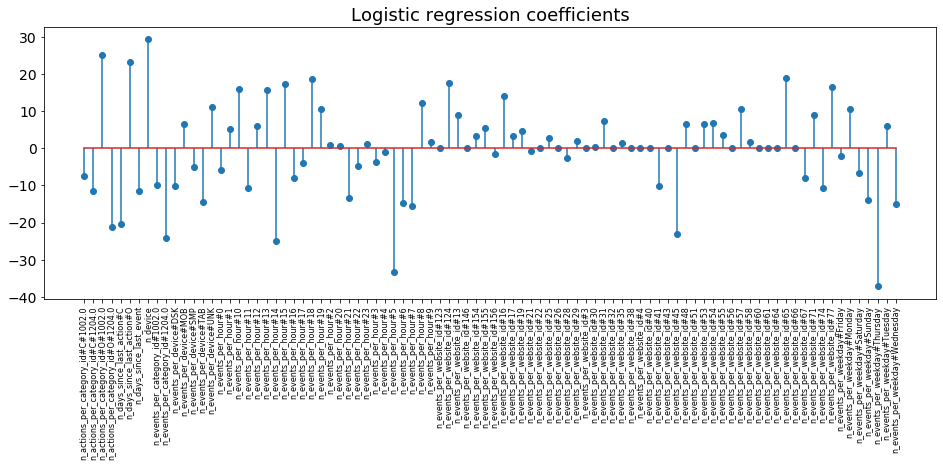

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 5))
plt.stem(clf.coef_[0], use_line_collection=True)
plt.title('Logistic regression coefficients', fontsize=18)
# We change the fontsize of minor ticks label
_ = plt.xticks(np.arange(clf.coef_[0].shape[0]), features_names, 
           rotation='vertical', fontsize=8)
_ = plt.yticks(fontsize=14)

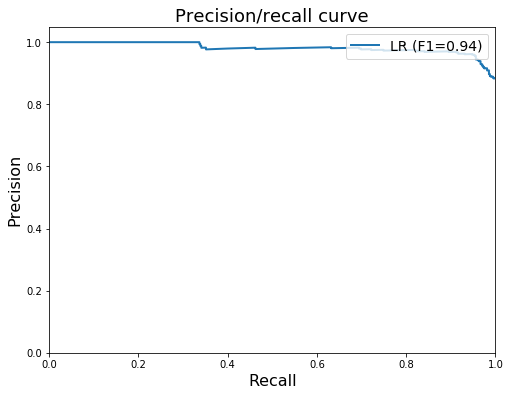

In [61]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='LR (F1=%.2f)' % f1_score(y_test, clf.predict(X_test)), lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision/recall curve', fontsize=18)
plt.legend(loc="upper right", fontsize=14)